# Выбор локации для скважины

# Постановка задачи
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_data_0.info()
geo_data_1.info()
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


В данных нет пропусков. Проверим как распределяются значения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdac0c4e210>,
      dtype=object)

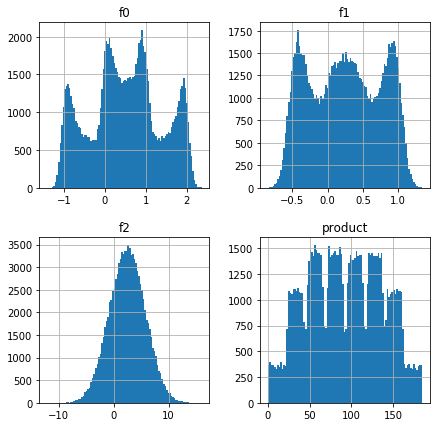

In [5]:
geo_data_0.hist(bins=100, figsize=(7,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdac02cef50>,
      dtype=object)

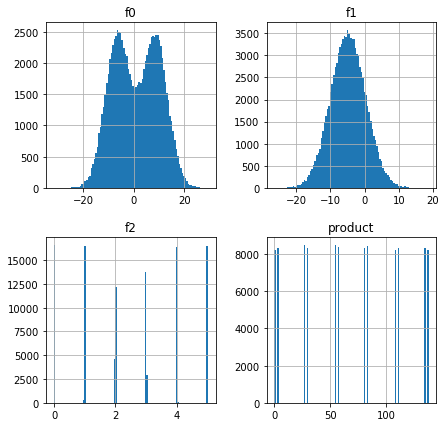

In [6]:
geo_data_1.hist(bins=100, figsize=(7,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdab711e550>,
      dtype=object)

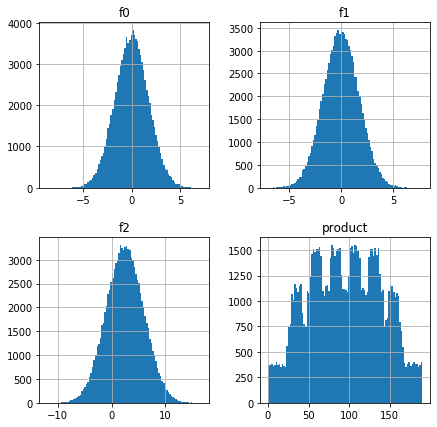

In [7]:
geo_data_2.hist(bins=100, figsize=(7,7))

In [8]:
print('Количество уникальных значений в признаке f2:',geo_data_1['f2'].nunique())
print('Уникальные значений в признаке product:\n',geo_data_1['product'].unique())

Количество уникальных значений в признаке f2: 100000
Уникальные значений в признаке product:
 [  3.17910258  26.95326103 134.76630516 137.94540774  84.03888568
 110.99214671  53.90652206   0.         107.81304413  57.08562465
  30.13236361  80.85978309]


Text(0.5, 1.0, 'Распределение f2 для значений product двух близких пиков (около 135 и 138)')

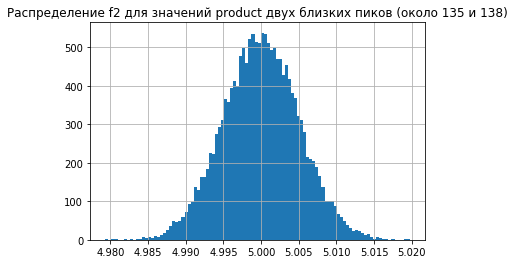

In [9]:
geo_data_1.query('product >= 134')['f2'].hist(bins=100)
plt.title('Распределение f2 для значений product двух близких пиков (около 135 и 138)')

Видно, что признак f2 в данных по второму региону распределен нормально около нескольких значений. Количество уникальных значений совпадает с количеством строк. В столбце product только 12 уникальных значений сгруппированых по два рядом. Такое рапсределдение выглядит искусственно созданным. Также можно заметить, что каждые два пика product формируют похожий пик у f2.     

Данная выборка не годится для работы, модель для неё всё равно обучим, но необходимо будет запросить дополнительные сведения по данным из этого региона. 

In [10]:
geo_0 = geo_data_0.drop(['id'],axis=1).round(4)
geo_1 = geo_data_1.drop(['id'],axis=1).round(4)
geo_2 = geo_data_2.drop(['id'],axis=1).round(4)

In [11]:
geo_0.corr().round(3)

,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144
f1,-0.441,1.000,0.002,-0.192
f2,-0.003,0.002,1.000,0.484
product,0.144,-0.192,0.484,1.000


In [12]:
geo_1.corr().round(3)

,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.030
f1,0.182,1.000,-0.003,-0.010
f2,-0.002,-0.003,1.000,0.999
product,-0.030,-0.010,0.999,1.000


In [13]:
geo_2.corr().round(3)

,f0,f1,f2,product
f0,1.000,0.001,-0.000,-0.002
f1,0.001,1.000,0.001,-0.001
f2,-0.000,0.001,1.000,0.446
product,-0.002,-0.001,0.446,1.000


Данные готовы для построения моделей. Во всех случаях f2 сильно коррелирует с product.

## Обучение и проверка модели
Выделим целевой признак.

In [14]:
features_0 = geo_0.drop('product',axis=1)
target_0 = geo_0['product']

In [15]:
def over_111(number):
    if number > 111:
        return 1
    return 0

In [16]:
features_1 = geo_1.drop('product',axis=1)
target_1 = geo_1['product']

In [17]:
features_2 = geo_2.drop('product',axis=1)
target_2 = geo_2['product']

In [18]:
log_target_0 = target_0.apply(over_111)
log_target_1 = target_1.apply(over_111)
log_target_2 = target_2.apply(over_111)

In [19]:
log_target_0

0        0
1        0
2        0
3        1
4        1
        ..
99995    0
99996    1
99997    0
99998    0
99999    1
Name: product, Length: 100000, dtype: int64

Разобьём выборки на тренировочную и валидационную.

In [20]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=0
)

In [21]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=1
)

In [22]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=2
)

Обучим модели. Из условия, для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

In [23]:
model_0 = LinearRegression().fit(features_train_0,target_train_0)
model_1 = LinearRegression().fit(features_train_1,target_train_1)
model_2 = LinearRegression().fit(features_train_2,target_train_2)

In [24]:
predicted_0 = model_0.predict(features_valid_0).round(3)
predicted_1 = model_1.predict(features_valid_1).round(3)
predicted_2 = model_2.predict(features_valid_2).round(3)

In [25]:
print('Средний запас предсказанного сырья для первого региона {:.2f}\n'.format(predicted_0.mean()),
      'Cреднеквадратичная ошибка {:.2f}'.format(mean_squared_error(target_valid_0, predicted_0) ** (1/2)))

Средний запас предсказанного сырья для первого региона 92.27
 Cреднеквадратичная ошибка 37.48


In [26]:
print('Средний запас предсказанного сырья для третьего региона {:.2f}\n'.format(predicted_2.mean()),
      'Cреднеквадратичная ошибка {:.2f}'.format(mean_squared_error(target_valid_2, predicted_2) ** (1/2)))

Средний запас предсказанного сырья для третьего региона 94.86
 Cреднеквадратичная ошибка 39.98


In [27]:
print('Средний запас предсказанного сырья для второго региона {:.2f}\n'.format(predicted_1.mean()),
      'Cреднеквадратичная ошибка {:.2f}'.format(mean_squared_error(target_valid_1, predicted_1) ** (1/2)))

Средний запас предсказанного сырья для второго региона 69.12
 Cреднеквадратичная ошибка 0.89


Как и ожидалось, для второго региона значения предсказания получились аномально точными.   
Среднее значение для первого и третьего регионов примерно равны около 92, 95 тыс. баррелей.   
Среднеквадратическая ошибка около 40 тыс.барралей, что является не самым лучшим результатом при среднем 92-95. Так как Максимальное значение около 180, то ошибка состовляет почти четверть. Необходимо будет учитывать это при расчете прибыли.  

## Подготовка к расчёту прибыли

Введёи всё показатели для расчета прибыли.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [28]:
total_wells = 500
select = 200
budget = 10 ** 10
barrel_gain = 450000
fail_probability = 0.025

Расситаем объём сырья для безубыточной разработки одной скважины

In [29]:
min_bar_value = budget / (select * barrel_gain)
round(min_bar_value,3)

111.111

Так как выбирают 200 скважин, то для покрытия бюджета они должны иметь хотя бы по 111.111 тыс. баррелей, это больше среднего на 15 - 20 тыс. баррелей, в зависимости от региона. Проведём расчет прибыли и рисков.

## Расчёт прибыли и рисков 
Ввёдем функцию, расчитывающую прибыль для самых потенциально богатых скважин. Проверим возможную прибыль техникой bootstrap.

In [35]:
def profit_1(target, predictions):
    pred_sorted = predictions.sort_values(ascending=False)[:200]
    select_points = target[pred_sorted.index]
    product = select_points.sum()
    rev = product * barrel_gain
    return rev - budget

In [36]:
def bootstrap(model, features, target):
    state = np.random.RandomState(12345)
    
    predictions = pd.Series(model.predict(features),index=features.index)
    
    profit = []
    for i in range(1000):
        sub_target = target.sample(n=500, replace=False, random_state=state)
        sub_predict = predictions[sub_target.index]
        
        profit.append(profit_1(sub_target, sub_predict))
    
    profit = pd.Series(profit)
    
    return profit

In [37]:
def profit_score(profit):    

    lower = profit.quantile(0.025)
    upper = profit.quantile(0.975)
    fail =  len(profit[profit < 0]) / len(profit)
    
    print('95% дверительный интервал выручки {}'.format([lower, upper]))
    print('Вероятность провала {:.2%}'.format(fail))
    print('Средняя выручка {}'.format(profit.mean()))

In [38]:
profit_score(bootstrap(model_0 ,features_0, target_0))

95% дверительный интервал выручки [-96992918.87499817, 908018750.3749999]
Вероятность провала 5.70%
Средняя выручка 419411692.025


In [39]:
profit_score(bootstrap(model_1 ,features_1, target_1))

95% дверительный интервал выручки [40959546.87500001, 861664152.4999999]
Вероятность провала 1.50%
Средняя выручка 451981999.6999998


In [40]:
profit_score(bootstrap(model_2 ,features_2, target_2))

95% дверительный интервал выручки [-112041366.62500004, 874625251.6249999]
Вероятность провала 6.70%
Средняя выручка 375682438.565


## Вывод   

При оценке потенциальной прибыльности регионов выяснилось, что только второй регион окупается с вероятностью 2.5%, но данный для него выглядят, как созданные искусственно. Рекомендовать этот регион можно только после проверки качества данных.

Остальные регионы окупаются с вероятностью:    
- Первый - 5.7%
- Третий - 6.7%